# Project setup

Before we do any machine learning we are going to have to setup our project by performing the necessary imports and using the right hardware



In [17]:
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.5.0


We will be using Google Colab's available GPUs to speed up our training and compile times:

In [18]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Our data has been uploaded to Google Drive so we need to get it from there and unzip it to be able to use it:

In [19]:
drive.mount('/content/drive')
!unzip -uq "/content/drive/MyDrive/voltron_ia/dataset_leaf.zip" -d "/content/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


As a general rule of thumb we'll define our project configuration as a series of constant insteads of using hard-coded values in our code.

In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
DATA_DIR = '/content/Voltron-Disease-Data/'
EPOCHS = 25
IMAGE_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3)
LABELS = ['HEALTHY', 'BLACK_ROT', 'ESCA', 'LEAF_BLIGHT']
OPTIMIZER = 'adam'
RANDOM_SEED = 42
VERBOSE = True

# Loading the data
The plant pathology data acquired has been split into two sub-categories train and validation. However we need another set which will be used for testing and evaluating the performance of the final model. To do this we will merge these sets and re-split them intotheir respective sets.

This is not need to perform any form of data balancing on this set as the imbalance in the data is neglible.

First we will create a list of all the file paths in both the training and validation sets:

In [21]:
train_data_dir = os.path.join(DATA_DIR, 'train/*/[!.]*') # Ingore any hidden files
validation_data_dir = os.path.join(DATA_DIR, 'valid/*/[!.]*') # Ignore any hidden files

files = tf.io.gfile.glob(train_data_dir)
files.extend(tf.io.gfile.glob(validation_data_dir))

Now we need to split the data using a commonly used ratio of 80:20 and load them in as datasets:


In [22]:
train_valid_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
train_files, validation_files = train_test_split(train_valid_files, test_size=0.2, random_state=42)

TRAIN_COUNT_HEALTHY = len([filename for filename in train_files if "/HEALTHY/" in filename])
TRAIN_COUNT_ESCA = len([filename for filename in train_files if "/ESCA/" in filename])
TRAIN_COUNT_LEAF_BLIGHT = len([filename for filename in train_files if "/LEAF_BLIGHT/" in filename])
TRAIN_COUNT_BLACK_ROT = len([filename for filename in train_files if "/BLACK_ROT/" in filename])

TRAIN_COUNT_SICK = TRAIN_COUNT_ESCA + TRAIN_COUNT_LEAF_BLIGHT + TRAIN_COUNT_BLACK_ROT

VAL_COUNT_HEALTHY = len([filename for filename in validation_files if "/HEALTHY/" in filename])
VAL_COUNT_ESCA = len([filename for filename in validation_files if "/ESCA/" in filename])
VAL_COUNT_LEAF_BLIGHT = len([filename for filename in validation_files if "/LEAF_BLIGHT/" in filename])
VAL_COUNT_BLACK_ROT = len([filename for filename in validation_files if "/BLACK_ROT/" in filename])

VAL_COUNT_SICK = VAL_COUNT_ESCA + VAL_COUNT_LEAF_BLIGHT + VAL_COUNT_BLACK_ROT

TEST_COUNT_HEALTHY = len([filename for filename in test_files if "/HEALTHY/" in filename])
TEST_COUNT_ESCA = len([filename for filename in test_files if "/ESCA/" in filename])
TEST_COUNT_LEAF_BLIGHT = len([filename for filename in test_files if "/LEAF_BLIGHT/" in filename])
TEST_COUNT_BLACK_ROT = len([filename for filename in test_files if "/BLACK_ROT/" in filename])

TEST_COUNT_SICK = TEST_COUNT_ESCA + TEST_COUNT_LEAF_BLIGHT + TEST_COUNT_BLACK_ROT

ds_train = tf.data.Dataset.from_tensor_slices(train_files)
ds_validation = tf.data.Dataset.from_tensor_slices(validation_files)
ds_test = tf.data.Dataset.from_tensor_slices(test_files)

print("Number of normal cases in the train dataset: " + str(TRAIN_COUNT_HEALTHY))
print("Number of ESCA cases in the train dataset: " + str(TRAIN_COUNT_ESCA))
print("Number of blight cases in the train dataset: " + str(TRAIN_COUNT_LEAF_BLIGHT))
print("Number of black rot cases in the train dataset: " + str(TRAIN_COUNT_BLACK_ROT))
print("Total number of sick cases in the train dataset: " + str(TRAIN_COUNT_SICK) + "\n\n")

print("Number of normal cases in the validation dataset: " + str(VAL_COUNT_HEALTHY))
print("Number of ESCA cases in the validation dataset: " + str(VAL_COUNT_ESCA))
print("Number of blight cases in the validation dataset: " + str(VAL_COUNT_LEAF_BLIGHT))
print("Number of black rot cases in the validation dataset: " + str(VAL_COUNT_BLACK_ROT))
print("Total number of sick cases in the validation dataset: " + str(VAL_COUNT_SICK) + "\n\n")

print("Number of normal cases in the test dataset: " + str(TEST_COUNT_HEALTHY))
print("Number of ESCA cases in the test dataset: " + str(TEST_COUNT_ESCA))
print("Number of blight cases in the test dataset: " + str(TEST_COUNT_LEAF_BLIGHT))
print("Number of black rot cases in the test dataset: " + str(TEST_COUNT_BLACK_ROT))
print("Total number of sick cases in the test dataset: " + str(TEST_COUNT_SICK))

Number of normal cases in the train dataset: 1349
Number of ESCA cases in the train dataset: 1556
Number of blight cases in the train dataset: 1365
Number of black rot cases in the train dataset: 1506
Total number of sick cases in the train dataset: 4427


Number of normal cases in the validation dataset: 336
Number of ESCA cases in the validation dataset: 391
Number of blight cases in the validation dataset: 348
Number of black rot cases in the validation dataset: 370
Total number of sick cases in the validation dataset: 1109


Number of normal cases in the test dataset: 430
Number of ESCA cases in the test dataset: 453
Number of blight cases in the test dataset: 439
Number of black rot cases in the test dataset: 484
Total number of sick cases in the test dataset: 1376


Up to this point our data set only consists of file paths but to be able to effectively train our models we are going to need a list of image and label pairs.

In [23]:
def decode_img(img_path):

    # Load the raw data from the file as a string tensor
    img = tf.io.read_file(img_path)
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0, 1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    img = tf.image.resize(img, IMAGE_SIZE)

    return img

def get_img_label(img_path):
    # Split the file path into a list of path components
    parts = tf.strings.split(img_path, os.path.sep)
    # The second to last component should be class/label of the image
    class_name = parts[-2]

    # Encode labels as positive(pneumonia) or negative(normal)
    if (class_name == LABELS[0]):
        return 0
    elif (class_name == LABELS[1]):
        return 1
    elif (class_name == LABELS[2]):
        return 2
    else:
        return 3

def process_path(img_path):
    label = get_img_label(img_path)
    img = decode_img(img_path)
    return img, label


# Get images and labels
ds_train = ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
ds_validation = ds_validation.map(process_path, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

# Getting a count of the records in the datasets
TRAIN_COUNT = tf.data.experimental.cardinality(ds_train).numpy()
VALIDATION_COUNT = tf.data.experimental.cardinality(ds_validation).numpy()
TEST_COUNT = tf.data.experimental.cardinality(ds_test).numpy()

# Ensuring the data has been split correctly
print("Number of training samples: " + str(TRAIN_COUNT))
print("Number of validation samples: " + str(VALIDATION_COUNT))
print("Number of test samples: " + str(TEST_COUNT))

Number of training samples: 5776
Number of validation samples: 1445
Number of test samples: 1806


## Configuring the data for performance


In [24]:
def configure_for_performance(ds, shuffle_buffer_size=1000):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


ds_train = configure_for_performance(ds_train, TRAIN_COUNT)
ds_validation = configure_for_performance(ds_validation, VALIDATION_COUNT)
ds_test = configure_for_performance(ds_test, TEST_COUNT)

## Visualizing the data

It's always a good idea to have a visualization of your data beforehand. Let's get a quick glance at our first batch:

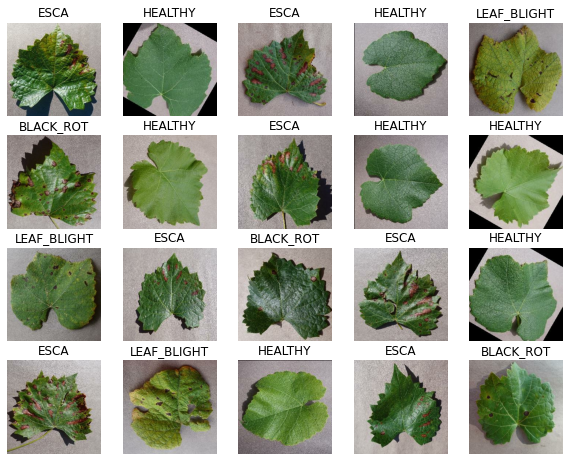

In [25]:
def plot_images(image_batch, label_batch=None, num_samples=10):
    plt.figure(figsize=(10, 10))
    for n in range(num_samples):
        ax = plt.subplot(5, 5, n+1)
        plt.imshow(image_batch[n])

        # Add labels if given
        if label_batch is not None:
            plt.title(LABELS[label_batch[n]])
        plt.axis("off")

image_batch, label_batch = next(iter(ds_train))
plot_images(image_batch.numpy(), label_batch, num_samples=20)

# Building our model

For this project we will be building a simple Convolutional Neural Network to classify our images.

In [26]:
def create_model():
    model = Sequential([
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=INPUT_SHAPE),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu'),
        layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.SeparableConv2D(256, (3, 3), padding='same', activation='relu'),
        layers.SeparableConv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.SeparableConv2D(256, (3, 3), padding='same', activation='relu'),
        layers.SeparableConv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),                                  
        layers.Dropout(0.2),
        layers.SeparableConv2D(512, (3, 3), padding='same', activation='relu'),
        layers.SeparableConv2D(512, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(units=256, activation='relu'),
        layers.Dropout(rate=0.5),
        layers.Dense(units=128, activation='relu'),
        layers.Dropout(rate=0.5),
        layers.Dense(units=64, activation='relu'),
        layers.Dropout(rate=0.3),
        layers.Dense(len(LABELS), activation='softmax')
    ])

    return model


# Training the model

For this example we will be categorizing the images into four groups: healthy, black rot, esca (black measles) and leaf blight. Since this is the case we will be using sparse categorical crossentropy as our loss function. 

For our metrics, we want to include precision and recall along with the accuracy as they will provide us with a more informed picture of how good our model is:

* Accuracy tells us the ratio of number of correct predictions to the total number of input samples. It is generally a good metric to begin with but doesn’t always tell the full story. It works well when the dataset is balanced but isn’t so useful when it isn’t. For example, consider that there are 98% samples of class A and 2% samples of class B in our training set. Then our model can easily get 98% training accuracy by simply predicting every training sample belonging to class A.  

* Precision is the number of correct positive results divided by the number of positive results predicted by the classifier. It is mainly useful in helping us to identify what percentage of our predictions were falsely classified as being cases of given class.

* Recall is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive).

In [27]:
with tf.device('/device:GPU:0'):
    model = create_model()

    METRICS = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
    ]

    CALLBACKS = [
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max'),
        tf.keras.callbacks.ModelCheckpoint("voltron_disease.h5", save_best_only=True)
    ]

    model.compile(
        optimizer=OPTIMIZER,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=METRICS
    )

    history = model.fit(
        ds_train,
        epochs=EPOCHS,
        validation_data=ds_validation,
        callbacks=CALLBACKS
    )


Epoch 1/25
91/91 [==============================] - 67s 722ms/step - loss: 1.0366 - accuracy: 0.5192 - val_loss: 1.4071 - val_accuracy: 0.2561
Epoch 2/25
91/91 [==============================] - 65s 710ms/step - loss: 0.5246 - accuracy: 0.8011 - val_loss: 1.4388 - val_accuracy: 0.2561
Epoch 3/25
91/91 [==============================] - 64s 708ms/step - loss: 0.3100 - accuracy: 0.9022 - val_loss: 1.6026 - val_accuracy: 0.2408
Epoch 4/25
91/91 [==============================] - 65s 709ms/step - loss: 0.2067 - accuracy: 0.9372 - val_loss: 1.5616 - val_accuracy: 0.2408
Epoch 5/25
91/91 [==============================] - 64s 707ms/step - loss: 0.2113 - accuracy: 0.9280 - val_loss: 3.0953 - val_accuracy: 0.2408
Epoch 6/25
91/91 [==============================] - 64s 708ms/step - loss: 0.1010 - accuracy: 0.9690 - val_loss: 4.5789 - val_accuracy: 0.2408
Epoch 7/25
91/91 [==============================] - 65s 709ms/step - loss: 0.1305 - accuracy: 0.9597 - val_loss: 1.5151 - val_accuracy: 0.2976

# Visualizing the training results

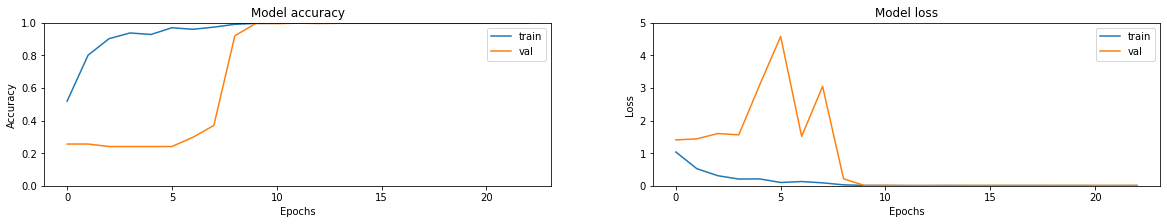

In [28]:
fig, axis= plt.subplots(1, 2, figsize=(20, 3))
axis = axis.ravel()

for idx, metric in enumerate(['accuracy', 'loss']):
    axis[idx].plot(history.history[metric])
    axis[idx].set_ylim([0, np.round(np.amax(history.history[metric]))])
    axis[idx].plot(history.history['val_' + metric])
    axis[idx].set_ylim([0, np.round(np.amax(history.history['val_' + metric]))])
    axis[idx].set_title('Model {}'.format(metric))
    axis[idx].set_xlabel('Epochs')
    axis[idx].set_ylabel(metric.capitalize())
    axis[idx].legend(['train', 'val'])


# Testing the model

Now that our model has been train, it's time to try it out on data it hasn't seen before to find out how well it generalizes.

In [29]:
loss, acc = model.evaluate(ds_test)

29/29 [==============================] - 5s 116ms/step - loss: 0.0175 - accuracy: 0.9950


Here we can see that we have an accuracy that is very close to what we attained during the training phase. This is a good sign and indicates that there is very little underfitting or overfitting in the model.

In this state our data might be difficult to understand so let's try displaying it differently to make it clearer. First lets show some examples of predictions:

Total number of test samples: 1806


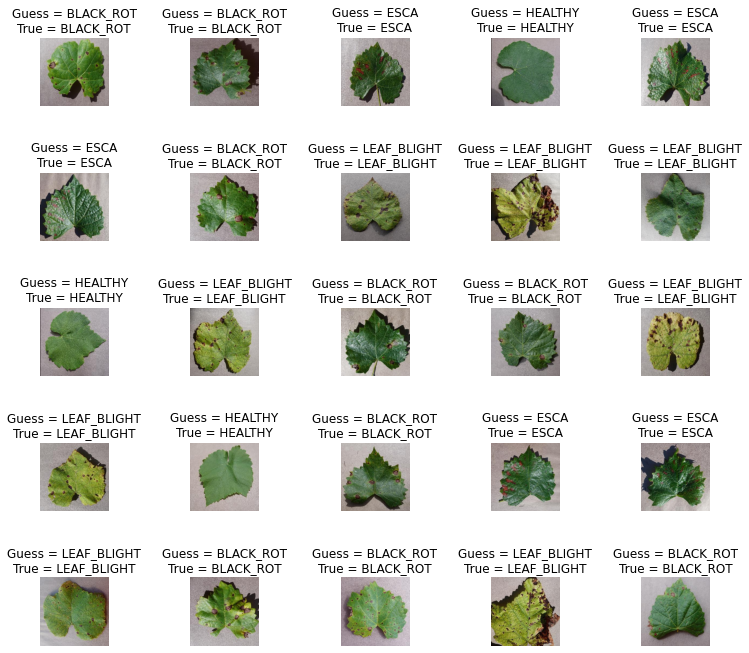

In [30]:
images = []
prediction_labels = []
true_labels = []

print("Total number of test samples: " + str(len(test_files)))
for idx in range(len(test_files)):
    img = cv2.imread(test_files[idx])
    img = cv2.resize(img, IMAGE_SIZE)
    img = img.astype('float32') / 255
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img_rgb)
    # Get original label
    parts = test_files[idx].split(os.path.sep)
    class_name = parts[-2]
    if (class_name == LABELS[0]):
        true_labels.append(0)
    elif (class_name == LABELS[1]):
        true_labels.append(1)
    elif (class_name == LABELS[2]):
        true_labels.append(2)
    else:
        true_labels.append(3)

predictions = model.predict(np.asarray(images))

fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.ravel()

rounded_predictions = np.argmax(predictions, axis=1)
for i in np.arange(0, 25):
    axes[i].imshow(images[i])
    axes[i].axis('off')
    pred_idx = rounded_predictions[i]
    axes[i].set_title('Guess = {}\nTrue = {}'.format(LABELS[pred_idx], LABELS[true_labels[i]]))

plt.subplots_adjust(wspace = 1.2)

While this may be pretty for demonstration it does not tell the full story. Let's generate a simple classification report of our model:

In [31]:
print("Classification Report\n\n")
print(classification_report(true_labels, rounded_predictions))

Classification Report


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       430
           1       0.99      0.99      0.99       484
           2       0.99      0.99      0.99       453
           3       1.00      1.00      1.00       439

    accuracy                           1.00      1806
   macro avg       1.00      1.00      1.00      1806
weighted avg       1.00      1.00      1.00      1806



Now lets display a confusion matrix of our test:

Text(87.0, 0.5, 'Original label')

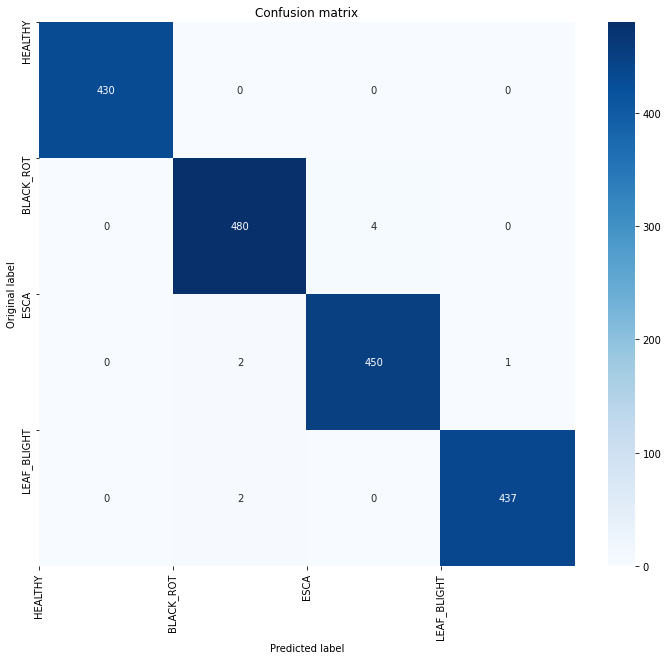

In [32]:
conf_mat = confusion_matrix(true_labels, rounded_predictions)

fig = plt.figure()
fig.set_figwidth(12)
fig.set_figheight(10)

ax = plt.subplot()
sns.heatmap(conf_mat, annot=True, ax=ax, cmap='Blues', fmt='g')

tick_marks = np.arange(len(LABELS))
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)


ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Original label')

From this confusion matrix we can see that there are very few images that we misclassify and the model performs very well. However all things can be improved, especially machine learning models. All thats left to do is test it in production.